In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.3 MB/s eta 0:00:00


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt

###########################################
# 1. Dataset & Dataloader
###########################################
class PrePostDataset(Dataset):
    def __init__(self, pre_dir, post_dir, img_size=(256, 256)):
        self.pre_files = sorted(os.listdir(pre_dir))
        self.post_files = sorted(os.listdir(post_dir))
        self.pre_dir = pre_dir
        self.post_dir = post_dir
        self.img_size = img_size

    def __len__(self):
        return len(self.pre_files)

    def __getitem__(self, idx):
        pre_path = os.path.join(self.pre_dir, self.pre_files[idx])
        pre_image = pydicom.dcmread(pre_path).pixel_array.astype(np.float32)

        # 정규화 [0,1]
        min_val, max_val = pre_image.min(), pre_image.max()
        if max_val - min_val > 0:
            pre_image = (pre_image - min_val) / (max_val - min_val)
        else:
            pre_image = np.zeros_like(pre_image)

        # [-1,1] 스케일링
        pre_image = pre_image * 2.0 - 1.0

        # 리사이즈
        pre_image = cv2.resize(pre_image, self.img_size)

        # Tensor 변환: [1,H,W]
        pre_image = torch.tensor(pre_image, dtype=torch.float32).unsqueeze(0)
        return pre_image


In [4]:
# 데이터 경로
data_dir = "/content/drive/MyDrive/tumorpred/data/train"
pre_dir = os.path.join(data_dir, "pre")
post_dir = os.path.join(data_dir, "post")

dataset = PrePostDataset(pre_dir, post_dir, img_size=(256,256))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [18]:
###########################################
# 2. Utilities: Sinusoidal Time Embedding
###########################################
def sinusoidal_time_embedding(t, dim=128, max_period=10000):
    half_dim = dim // 2
    freqs = torch.exp(
        -torch.log(torch.tensor(max_period)) * torch.arange(0, half_dim, dtype=torch.float32) / float(half_dim)
    ).to(t.device)
    args = t[:, None] * freqs[None, :]
    embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return embedding


In [19]:
###########################################
# 3. Simple UNet for DDPM
###########################################
class SimpleBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        groups = min(8, out_ch)
        if out_ch % groups != 0:
            groups = 1  # 최후의 수단: 그룹 수를 1로 설정해 InstanceNorm처럼 사용
        self.groupnorm1 = nn.GroupNorm(groups, out_ch)
        self.groupnorm2 = nn.GroupNorm(groups, out_ch)

    def forward(self, x, t_emb):
        t = self.time_mlp(t_emb)[:, :, None, None]
        x = self.conv1(x)
        x = self.groupnorm1(x)
        x = F.relu(x)

        x = x + t
        x = self.conv2(x)
        x = self.groupnorm2(x)
        x = F.relu(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128):
        super().__init__()
        self.time_emb_dim = time_emb_dim

        # Down blocks
        self.down1 = SimpleBlock(in_channels, 64, time_emb_dim)
        self.downsample1 = nn.Conv2d(64, 64, 4, 2, 1)  # out: 64
        self.down2 = SimpleBlock(64, 128, time_emb_dim)
        self.downsample2 = nn.Conv2d(128, 128, 4, 2, 1) # out: 128
        self.down3 = SimpleBlock(128, 256, time_emb_dim)

        # Mid
        self.mid = SimpleBlock(256, 256, time_emb_dim)

        # Up blocks
        # up3: input = upsample(mid) + x2 = 256 + 128 = 384 -> 128
        self.upsample2 = nn.ConvTranspose2d(256, 256, 4, 2, 1) # mid upsample
        self.up3 = SimpleBlock(384, 128, time_emb_dim)

        # up2: input = upsample(up3_out=128) + x1=64 => 128 +64=192 ->64
        self.upsample1 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.up2 = SimpleBlock(192, 64, time_emb_dim)

        # up1: input = upsample(up2_out=64) -> no concat here, just use up2_out directly
        # 여기에 추가 업샘플이 필요하다면 정의, 여기서는 top level에서 더이상 upsample 없음
        # 최종 출력으로 가기 위해 SimpleBlock 대신 Conv만 사용할 수도 있음
        # 하지만 일관성 위해 SimpleBlock 사용
        # 여기서는 추가 업샘플 없이 최종 out으로
        self.up1 = SimpleBlock(64, out_channels, time_emb_dim)

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, self.time_emb_dim)

        # Down
        x1 = self.down1(x, t_emb)  # out:64
        x2_in = self.downsample1(x1) # out:64,H/2
        x2 = self.down2(x2_in, t_emb) # out:128
        x3_in = self.downsample2(x2) # out:128,H/4
        x3 = self.down3(x3_in, t_emb) # out:256,H/4

        # Mid
        x_mid = self.mid(x3, t_emb) # out:256

        # Up
        x_ = self.upsample2(x_mid)  # out:256,H/2
        x_ = torch.cat([x_, x2], dim=1)  # 256+128=384
        x_ = self.up3(x_, t_emb) # out:128,H/2

        x_ = self.upsample1(x_) # out:128,H
        x_ = torch.cat([x_, x1], dim=1) # 128+64=192
        x_ = self.up2(x_, t_emb) # out:64,H

        # top level without concat
        x_ = self.up1(x_, t_emb) # out:1,H,W

        return x_


In [20]:
###########################################
# 4. DDPM Class
###########################################
class DDPM(nn.Module):
    def __init__(self, model, timesteps=1000, device="cuda"):
        super().__init__()
        self.model = model
        self.timesteps = timesteps
        self.device = device

        # beta schedule (linear)
        self.betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x0, t):
        # q(x_t|x_0) = N(x_t; sqrt(alpha_bar_t)*x_0, (1-alpha_bar_t)*I)
        # t: [batch], x0: [B, C, H, W]
        alpha_bar_t = self.alpha_bars[t].view(-1,1,1,1)
        noise = torch.randn_like(x0)
        x_t = torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1 - alpha_bar_t)*noise
        return x_t, noise

    def p_sample(self, x_t, t):
        # reverse step: model predicts noise
        # DDPM reverse step (without variance adjustment for simplicity):
        # x_{t-1} = (1/sqrt(alpha_t))*(x_t - ((1 - alpha_t)/sqrt(1 - alpha_bar_t)) * pred_noise)
        alpha_t = self.alphas[t].view(-1,1,1,1)
        alpha_bar_t = self.alpha_bars[t].view(-1,1,1,1)
        pred_noise = self.model(x_t, t.float()/self.timesteps)

        # If t > 0 add noise
        if t[0] > 0:
            # Posterior q(x_{t-1}|x_t,x_0) variance is beta_t
            beta_t = self.betas[t].view(-1,1,1,1)
            # The DDPM sampling formula (simplified):
            mean = (1.0/torch.sqrt(alpha_t))*(x_t - ((1 - alpha_t)/(torch.sqrt(1 - alpha_bar_t)))*pred_noise)
            z = torch.randn_like(x_t)
            x_t_minus_1 = mean + torch.sqrt(beta_t)*z
        else:
            # at t=0, no noise addition
            mean = (1.0/torch.sqrt(alpha_t))*(x_t - ((1 - alpha_t)/(torch.sqrt(1 - alpha_bar_t)))*pred_noise)
            x_t_minus_1 = mean
        return x_t_minus_1

    @torch.no_grad()
    def sample(self, shape, num_inference_steps=None):
        # num_inference_steps: if not None, use fewer steps (DDIM like)
        if num_inference_steps is None:
            num_inference_steps = self.timesteps

        # choose a subset of t steps
        all_steps = torch.arange(self.timesteps-1, -1, -1, device=self.device)
        if num_inference_steps < self.timesteps:
            # for simplicity, just take evenly spaced steps
            step_indices = torch.linspace(0, self.timesteps-1, num_inference_steps).long()
            steps = all_steps[step_indices]
        else:
            steps = all_steps

        x = torch.randn(shape, device=self.device) # start from pure noise
        for i, step in enumerate(steps):
            t = torch.tensor([step]*shape[0], device=self.device)
            x = self.p_sample(x, t)
        return x

In [23]:
###########################################
# 5. Training Loop
###########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1, time_emb_dim=128).to(device)
ddpm = DDPM(model, timesteps=1000, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
mse_loss = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    for step, x0 in enumerate(dataloader):
        x0 = x0.to(device) # x0: original image
        # random t
        t = torch.randint(0, ddpm.timesteps, (x0.size(0),), device=device)
        # q_sample
        x_t, noise = ddpm.q_sample(x0, t)

        # predict noise
        pred_noise = model(x_t, t.float()/ddpm.timesteps)
        loss = mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")


Epoch [1/50] Loss: 0.6773
Epoch [2/50] Loss: 0.5894
Epoch [3/50] Loss: 0.5663
Epoch [4/50] Loss: 0.5474
Epoch [5/50] Loss: 0.5594
Epoch [6/50] Loss: 0.5301
Epoch [7/50] Loss: 0.5199
Epoch [8/50] Loss: 0.5264
Epoch [9/50] Loss: 0.5142
Epoch [10/50] Loss: 0.5170
Epoch [11/50] Loss: 0.5172
Epoch [12/50] Loss: 0.5137
Epoch [13/50] Loss: 0.5470
Epoch [14/50] Loss: 0.5165
Epoch [15/50] Loss: 0.5094
Epoch [16/50] Loss: 0.5110
Epoch [17/50] Loss: 0.5060
Epoch [18/50] Loss: 0.5063
Epoch [19/50] Loss: 0.5343
Epoch [20/50] Loss: 0.5172
Epoch [21/50] Loss: 0.5068
Epoch [22/50] Loss: 0.5060
Epoch [23/50] Loss: 0.5033
Epoch [24/50] Loss: 0.5100
Epoch [25/50] Loss: 0.5212
Epoch [26/50] Loss: 0.5008
Epoch [27/50] Loss: 0.5049
Epoch [28/50] Loss: 0.5016
Epoch [29/50] Loss: 0.5051
Epoch [30/50] Loss: 0.5117
Epoch [31/50] Loss: 0.5024
Epoch [32/50] Loss: 0.5093
Epoch [33/50] Loss: 0.5038
Epoch [34/50] Loss: 0.5055
Epoch [35/50] Loss: 0.5058
Epoch [36/50] Loss: 0.5074
Epoch [37/50] Loss: 0.5116
Epoch [38/

Epoch [1/100], Loss: 0.9979
Epoch [2/100], Loss: 1.0025
Epoch [3/100], Loss: 0.9997
Epoch [4/100], Loss: 1.0018
Epoch [5/100], Loss: 1.0000
Epoch [6/100], Loss: 1.0052
Epoch [7/100], Loss: 0.9976
Epoch [8/100], Loss: 1.0030
Epoch [9/100], Loss: 0.9992
Epoch [10/100], Loss: 0.9981


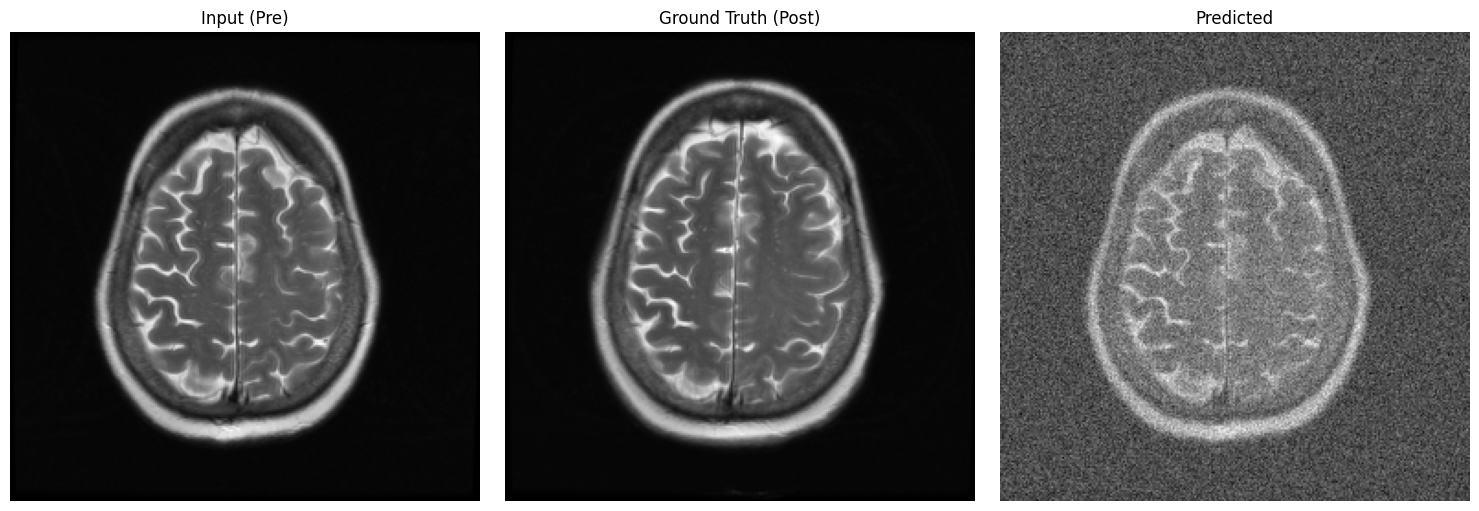

Epoch [11/100], Loss: 1.0000
Epoch [12/100], Loss: 1.0009
Epoch [13/100], Loss: 0.9994
Epoch [14/100], Loss: 0.9987
Epoch [15/100], Loss: 0.9997
Epoch [16/100], Loss: 0.9994
Epoch [17/100], Loss: 0.9980
Epoch [18/100], Loss: 0.9971
Epoch [19/100], Loss: 1.0008
Epoch [20/100], Loss: 1.0014


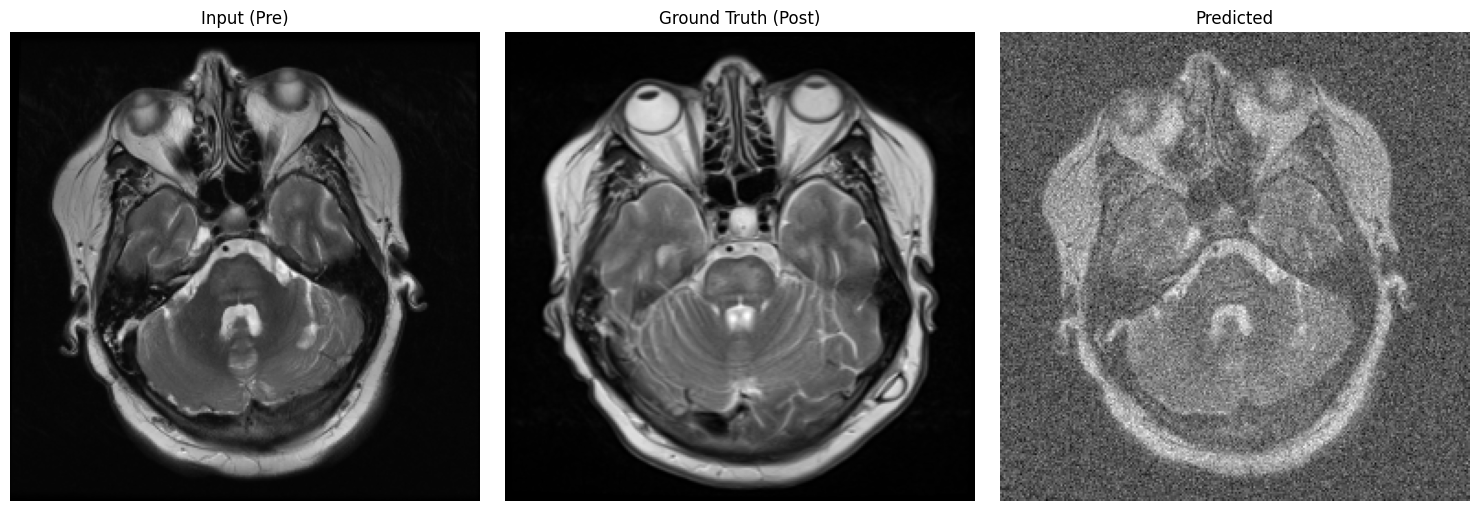

Epoch [21/100], Loss: 0.9980
Epoch [22/100], Loss: 1.0011
Epoch [23/100], Loss: 1.0000
Epoch [24/100], Loss: 0.9979
Epoch [25/100], Loss: 0.9972
Epoch [26/100], Loss: 0.9964
Epoch [27/100], Loss: 1.0011
Epoch [28/100], Loss: 1.0018
Epoch [29/100], Loss: 1.0033
Epoch [30/100], Loss: 0.9951


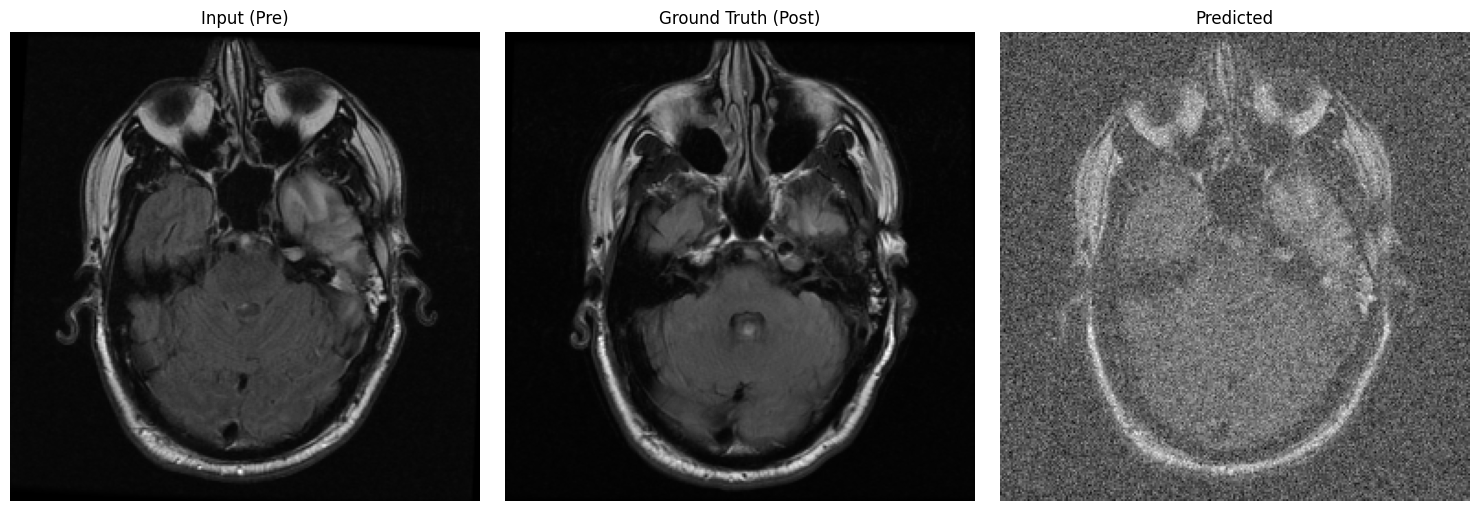

Epoch [31/100], Loss: 1.0019
Epoch [32/100], Loss: 1.0000
Epoch [33/100], Loss: 1.0005
Epoch [34/100], Loss: 0.9992
Epoch [35/100], Loss: 1.0006
Epoch [36/100], Loss: 0.9979
Epoch [37/100], Loss: 0.9980
Epoch [38/100], Loss: 0.9961
Epoch [39/100], Loss: 1.0009
Epoch [40/100], Loss: 1.0023


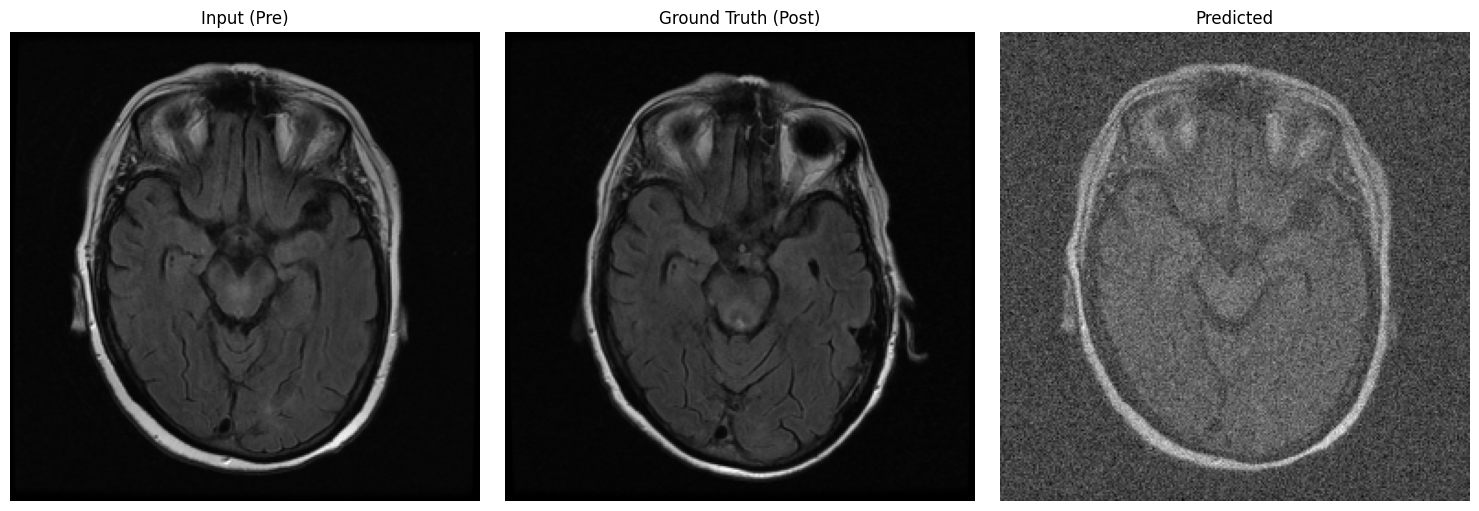

Epoch [41/100], Loss: 1.0002
Epoch [42/100], Loss: 1.0023
Epoch [43/100], Loss: 1.0019
Epoch [44/100], Loss: 0.9987
Epoch [45/100], Loss: 0.9980
Epoch [46/100], Loss: 0.9994
Epoch [47/100], Loss: 0.9970
Epoch [48/100], Loss: 0.9983
Epoch [49/100], Loss: 1.0023
Epoch [50/100], Loss: 0.9988


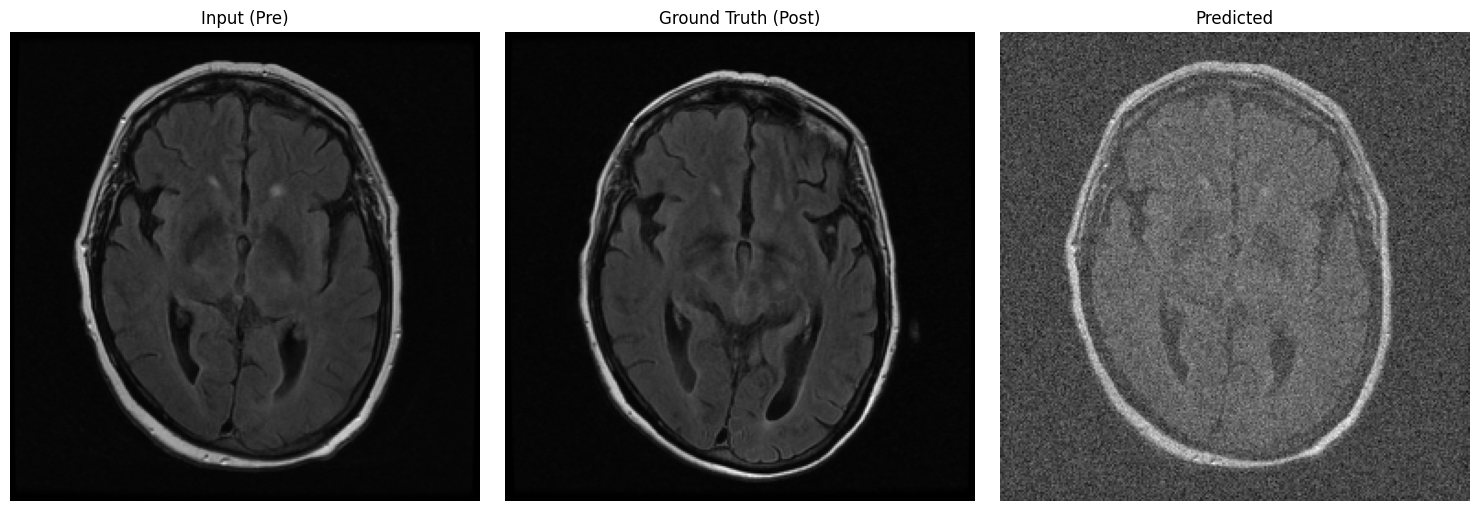

Epoch [51/100], Loss: 1.0020
Epoch [52/100], Loss: 0.9986
Epoch [53/100], Loss: 1.0003
Epoch [54/100], Loss: 1.0010
Epoch [55/100], Loss: 0.9998
Epoch [56/100], Loss: 1.0006
Epoch [57/100], Loss: 0.9978
Epoch [58/100], Loss: 1.0004
Epoch [59/100], Loss: 1.0041
Epoch [60/100], Loss: 0.9997


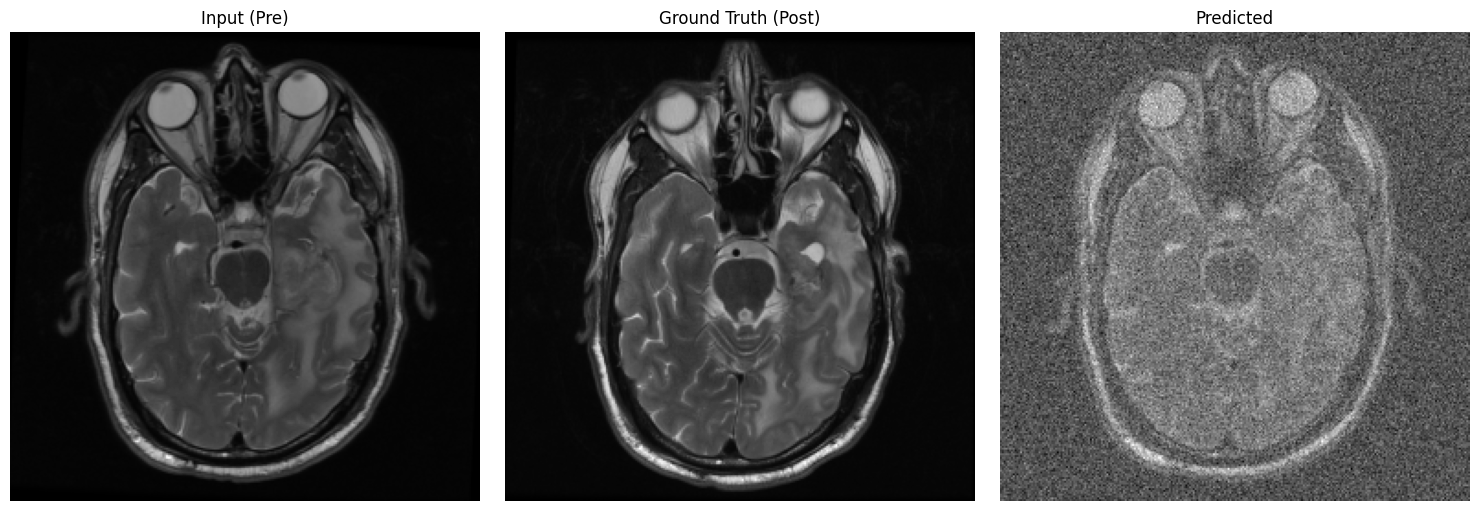

Epoch [61/100], Loss: 0.9998
Epoch [62/100], Loss: 1.0000
Epoch [63/100], Loss: 0.9975
Epoch [64/100], Loss: 1.0045
Epoch [65/100], Loss: 0.9992
Epoch [66/100], Loss: 1.0020
Epoch [67/100], Loss: 1.0009
Epoch [68/100], Loss: 0.9991
Epoch [69/100], Loss: 1.0010
Epoch [70/100], Loss: 1.0001


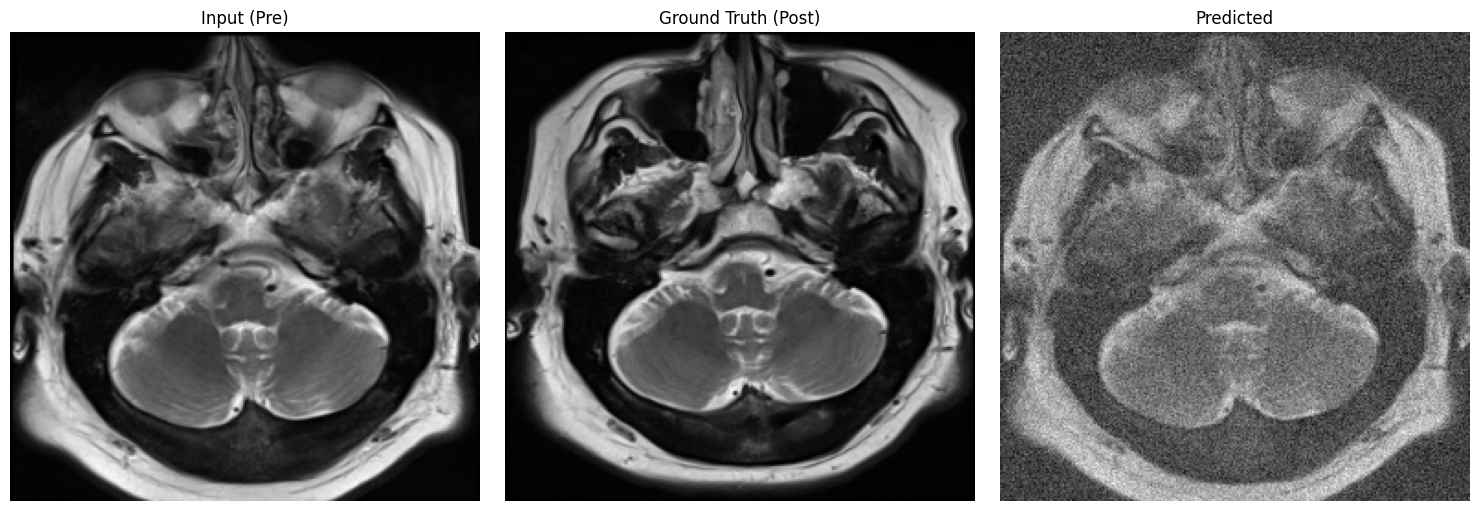

Epoch [71/100], Loss: 1.0009
Epoch [72/100], Loss: 0.9970
Epoch [73/100], Loss: 0.9974
Epoch [74/100], Loss: 1.0030
Epoch [75/100], Loss: 1.0029
Epoch [76/100], Loss: 1.0001
Epoch [77/100], Loss: 1.0008
Epoch [78/100], Loss: 1.0003
Epoch [79/100], Loss: 1.0025
Epoch [80/100], Loss: 1.0007


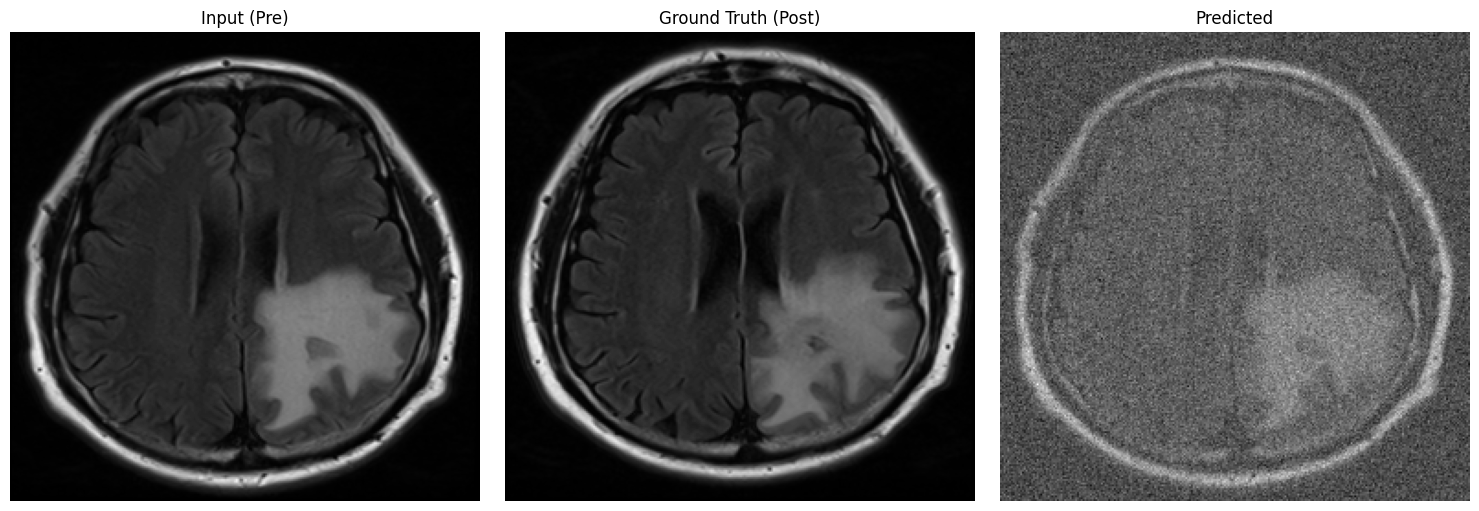

Epoch [81/100], Loss: 0.9992
Epoch [82/100], Loss: 0.9977
Epoch [83/100], Loss: 1.0003
Epoch [84/100], Loss: 1.0006
Epoch [85/100], Loss: 0.9993
Epoch [86/100], Loss: 0.9994
Epoch [87/100], Loss: 0.9995
Epoch [88/100], Loss: 1.0007
Epoch [89/100], Loss: 1.0001
Epoch [90/100], Loss: 0.9992


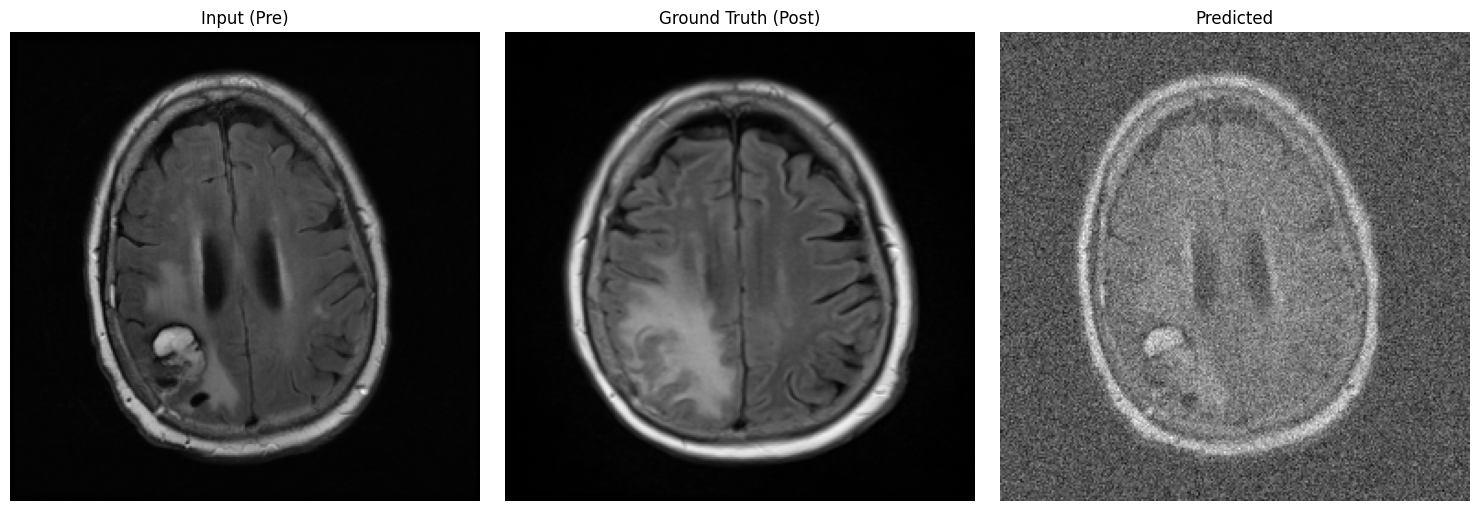

Epoch [91/100], Loss: 1.0043
Epoch [92/100], Loss: 0.9986
Epoch [93/100], Loss: 0.9987
Epoch [94/100], Loss: 1.0004
Epoch [95/100], Loss: 1.0011
Epoch [96/100], Loss: 0.9975
Epoch [97/100], Loss: 1.0006
Epoch [98/100], Loss: 1.0013
Epoch [99/100], Loss: 1.0029
Epoch [100/100], Loss: 1.0000


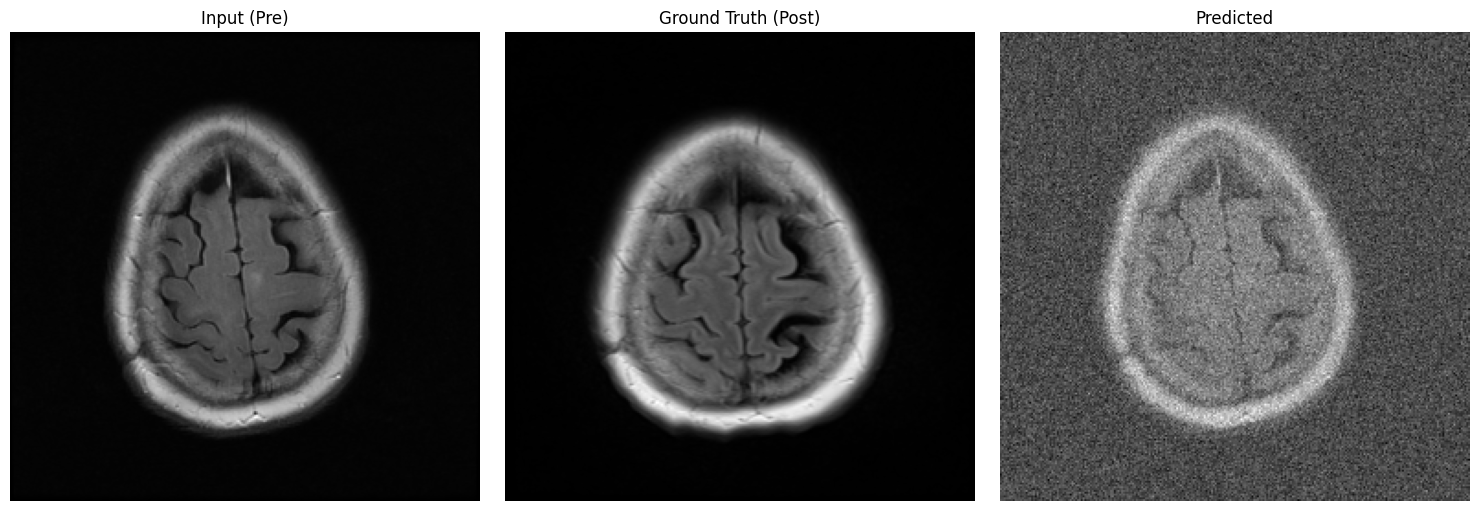

In [ ]:
epochs = 100
for epoch in range(epochs):
    for step, x0 in enumerate(dataloader):
        x0 = x0.to(device) # x0: original image
        # random t
        t = torch.randint(0, ddpm.timesteps, (x0.size(0),), device=device)
        # q_sample
        x_t, noise = ddpm.q_sample(x0, t)

        # predict noise
        pred_noise = model(x_t, t.float()/ddpm.timesteps)
        loss = mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")

    # 예측 결과 시각화
    if (epoch + 1) % 10 == 0:  # 매 10 epoch마다 결과 확인
        with torch.no_grad():
            for pre_image, post_image in dataloader:
                pre_image = pre_image.to(device)

                # Forward Process
                noisy_image, _, _ = ddpm.forward_process(pre_image)

                # t=0으로 배치 크기만큼 복제
                t = torch.zeros(pre_image.size(0), device=device).float() / ddpm.timesteps
                t_embed = t.unsqueeze(1)  # [batch_size, 1]

                # Predict Noise
                pred_noise = model(noisy_image, t_embed)  # Predict noise
                reconstructed_image = noisy_image - pred_noise  # Reconstruct image

                # 시각화
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(pre_image[0, 0].cpu().numpy(), cmap='gray')
                plt.title("Input (Pre)")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(post_image[0, 0].cpu().numpy(), cmap='gray')
                plt.title("Ground Truth (Post)")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(reconstructed_image[0, 0].cpu().numpy(), cmap='gray')
                plt.title("Predicted")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
                break  # 첫 번째 배치만 시각화